In [94]:
from initialization import Location
from initialization import Grid
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base Model

In [95]:

# Parameters
beta = 0.3 
mu = 0.1  
population = 1000 
initial_infected = 1  
initial_susceptible = population - initial_infected  
initial_recovered = 0 
days = 100  

# Create arrays to store the results
susceptible = np.zeros(days)
infectious = np.zeros(days)
recovered = np.zeros(days)

# Initialize the initial conditions
susceptible[0] = initial_susceptible
infectious[0] = initial_infected
recovered[0] = initial_recovered

# Simulate the SIR model
for day in range(1, days):
    new_infections = beta * susceptible[day - 1] * infectious[day - 1] / population
    new_recoveries = mu * infectious[day - 1]

    susceptible[day] = susceptible[day - 1] - new_infections
    infectious[day] = infectious[day - 1] + new_infections - new_recoveries
    recovered[day] = recovered[day - 1] + new_recoveries



# Mobility-Based Model

In [96]:

def get_other_loc_params(grid,loc):
    infections = 0
    total_connections = 0
    for j in loc.connections:
        if grid.map[j].n != 0:
            infections += loc.connections[j] * (grid.map[j].i / grid.map[j].n)
            total_connections += loc.connections[j]
    
    return infections, total_connections

### Random Origin w/ Dynamic Alpha

In [97]:
def dynamic_alpha():
    # Parameters
    beta = 0.3 #rate of infection *CHANGE LATER MAYBE*
    mu = 0.1 #rate of recovery *CHANGE LATER MAYBE*
    N = 1000 
    n_locations=10
    days = 100
    alphas = np.arange(0.1,1.1,0.1)
    alpha=0.5
    trials=10

    alpha_sir = {}
    for alpha in alphas:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            #Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            #initialize random starting location
            grid.random_orgin()

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [98]:
dynamic_alpha_results = dynamic_alpha()
dynamic_alpha_results

{0.1: [[1,
   0.9987025213488725,
   0.9983212329271013,
   0.997832232554965,
   0.9972048286182992,
   0.9963998910838471,
   0.9953679737849465,
   0.9940472981291681,
   0.9923618204759865,
   0.9902197611454625,
   0.987513096789377,
   0.9841185447074294,
   0.9799004283553532,
   0.9747154374549855,
   0.9684186524704964,
   0.9608693902942512,
   0.9519347450867744,
   0.9414885860684202,
   0.9294046289379497,
   0.9155442206941596,
   0.8997425995613383,
   0.8818009939348139,
   0.8614943642989851,
   0.8386034000333269,
   0.8129727500083546,
   0.7845860756720543,
   0.7536362962949563,
   0.7205627205382458,
   0.6860318222880787,
   0.6508567381746988,
   0.6158751998302997,
   0.5818233599290676,
   0.549243588399151,
   0.5184484706069576,
   0.4895407043078508,
   0.46247030661006394,
   0.4371030490464293,
   0.41327797791019066,
   0.3908430673641644,
   0.3696702538694263,
   0.34965860686471234,
   0.33073432424452476,
   0.3128506729401279,
   0.295985651169732,


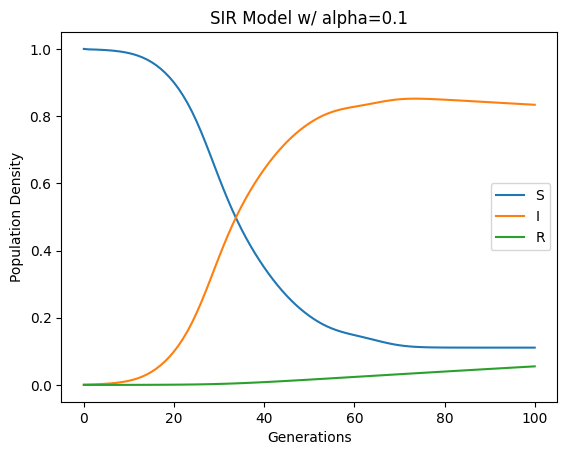

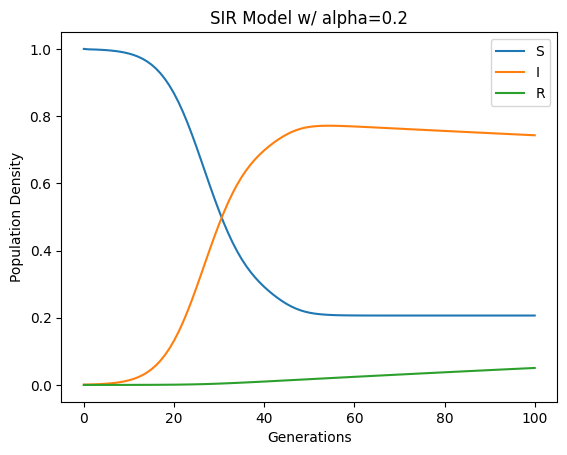

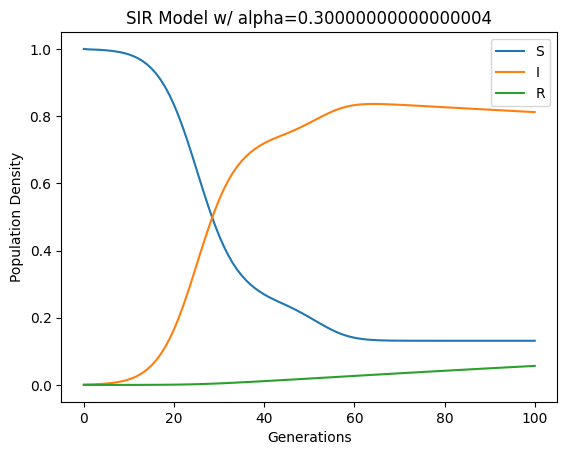

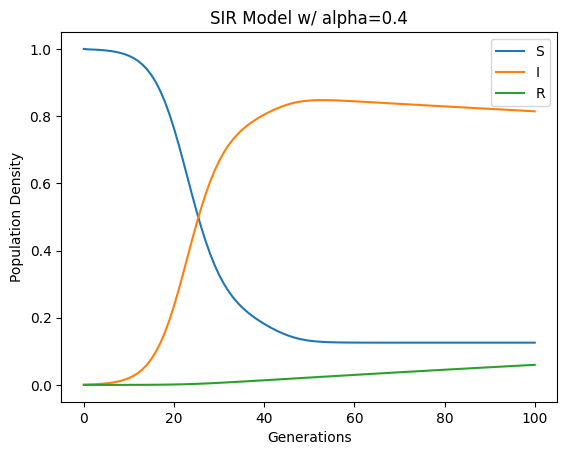

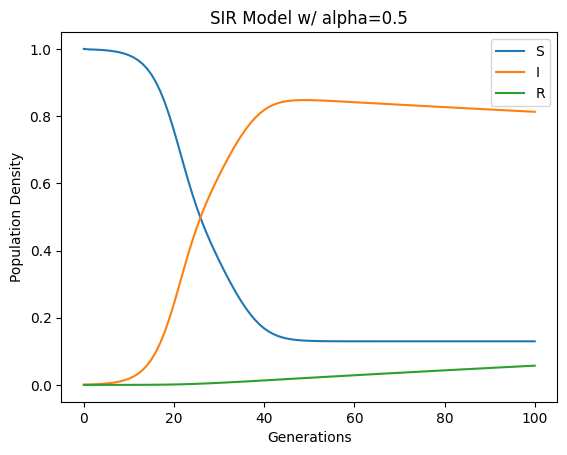

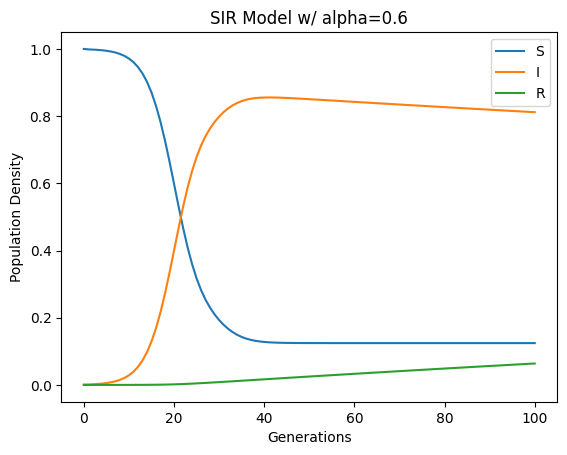

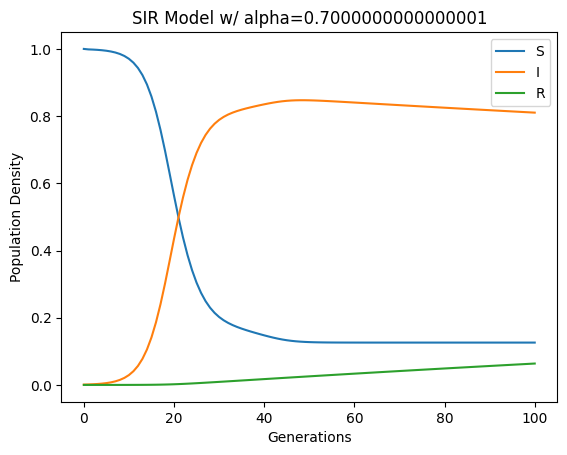

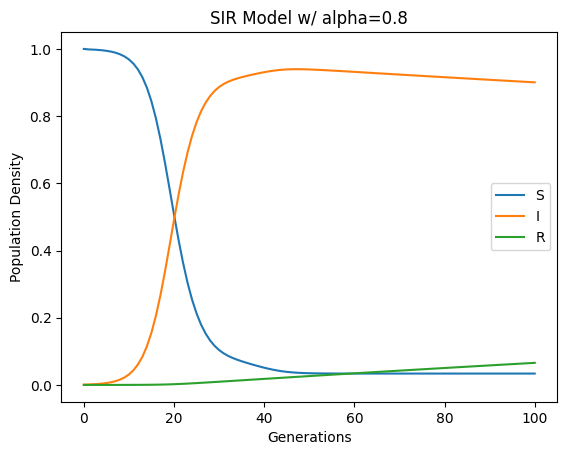

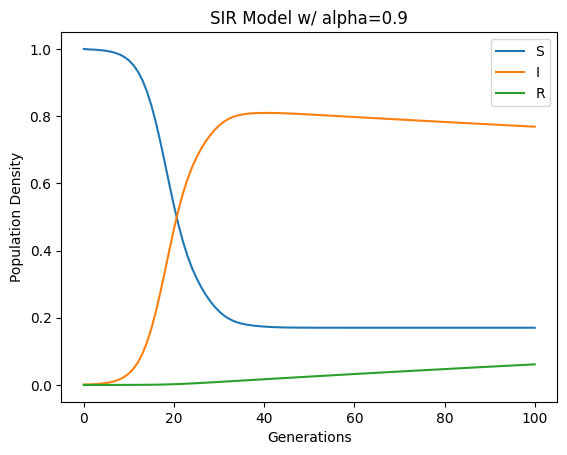

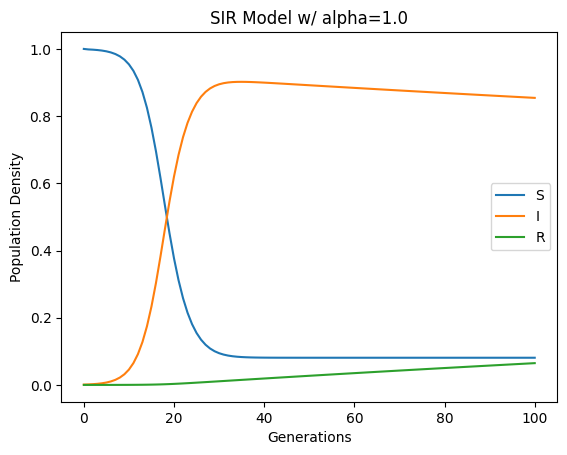

In [99]:
translation = {0:"S", 1:"I", 2:"R"}
for key, values in dynamic_alpha_results.items():
    plt.figure()
    for sublist in values:
        # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
        plt.plot(sublist, label=translation[values.index(sublist)])
        plt.title(f'SIR Model w/ alpha={key}')

    plt.legend()
    plt.xlabel("Generations")
    plt.ylabel("Population Density")
    
plt.show()

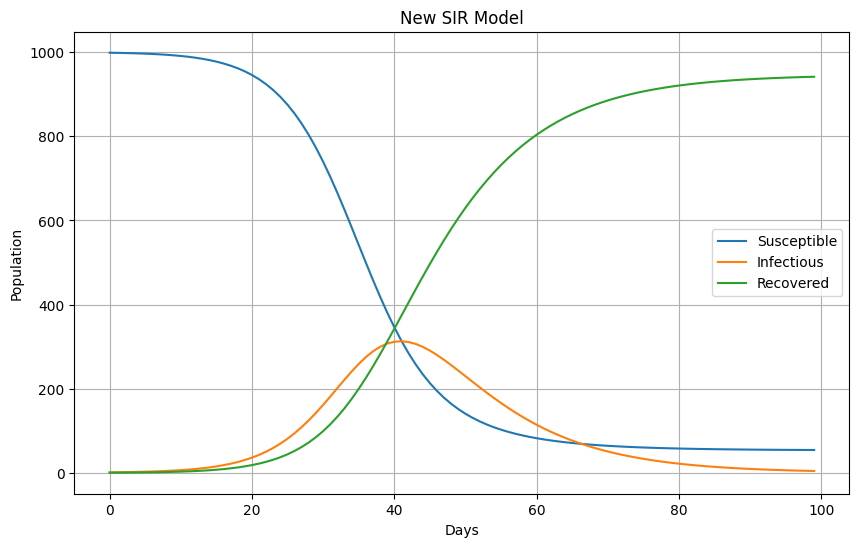

In [100]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(susceptible, label="Susceptible")
plt.plot(infectious, label="Infectious")
plt.plot(recovered, label="Recovered")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.title("New SIR Model")
plt.grid(True)
plt.show()

# Mobility Based SIR Models - Random, High, and Low

In [101]:
def dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alpha_range, trials):
    alpha_sir = {}
    for alpha in alpha_range:

        # Create arrays to store the results
        susceptible = np.zeros(days)
        infectious = np.zeros(days)
        recovered = np.zeros(days) 
        for trial in range(trials):
    
            # Initialize grid and locations
            grid = Grid(n_locations, N, alpha, beta, mu)

            # Initialize random starting location based on chosen Mobility Type
            if type == "Random":
                grid.random_orgin()
            elif type == "High Mobility":
                grid.mobility_based_origin(threshold, True)
            else:
                grid.mobility_based_origin(threshold, False)
                

            for day in range(days):
                for loc in grid.map:
                    if loc.n != 0:
                        infections, total_connections = get_other_loc_params(grid, loc)
                        
                        new_infections = (beta * loc.s * loc.i/ loc.n) + ((alpha*loc.s*infections*beta)/(loc.n+total_connections))
                        
                        new_recoveries = (mu * loc.i) / loc.n

                        loc.s = loc.s - new_infections
                        loc.i = loc.i + new_infections - new_recoveries
                        loc.r = loc.r + new_recoveries

                        susceptible[day] += loc.s
                        infectious[day] += loc.i
                        recovered[day] += loc.r

        susceptible = [day / (trials*N) for day in susceptible]
        infectious = [day / (trials*N) for day in infectious]
        recovered = [day / (trials*N) for day in recovered]

        susceptible.insert(0,1)
        infectious.insert(0,1/N)
        recovered.insert(0,0)

        alpha_sir[alpha] = [susceptible, infectious, recovered]
    return alpha_sir

In [102]:
def sir_plotting(results, type):
    for key, values in results:
        plt.figure()
        for sublist in values:
            # plt.plot(sublist, label=f'{key}_{values.index(sublist)}')
            plt.plot(sublist, label=translation[values.index(sublist)])
            plt.title(f'SIR Model w/ {type} Mobility: Alpha = {key}')

        plt.legend()
        plt.xlabel("Generations")
        plt.ylabel("Population Density")
    plt.show()

### SIR Model with Random Origin and Dynamic Alpha

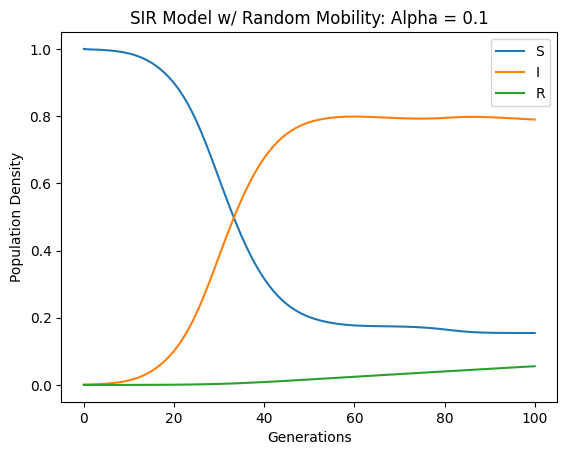

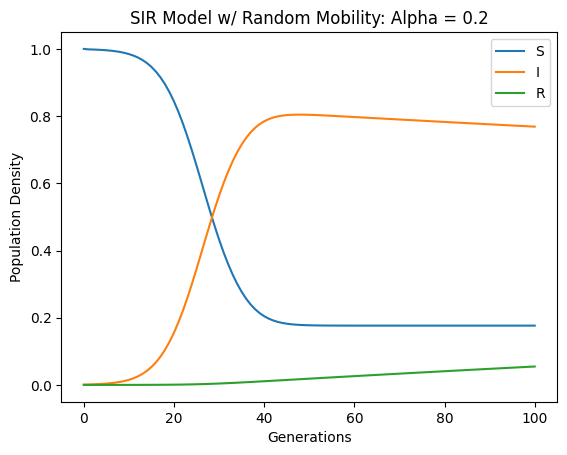

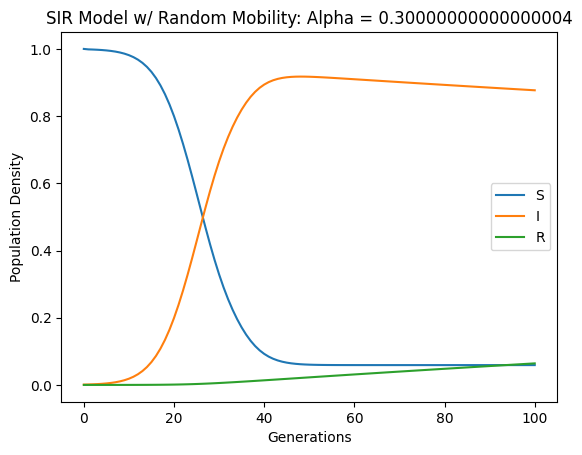

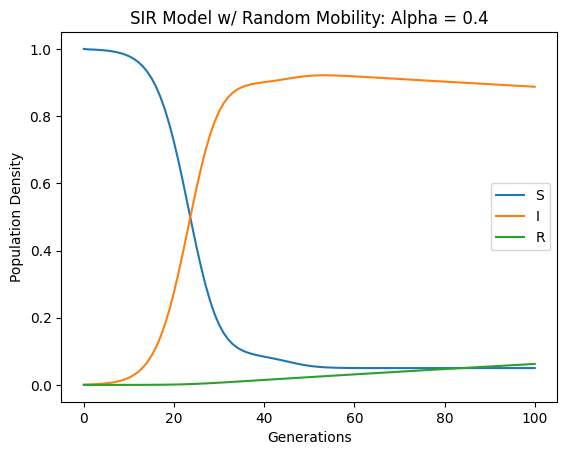

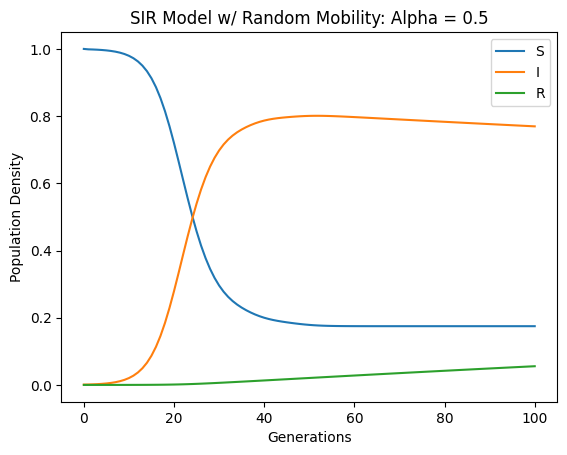

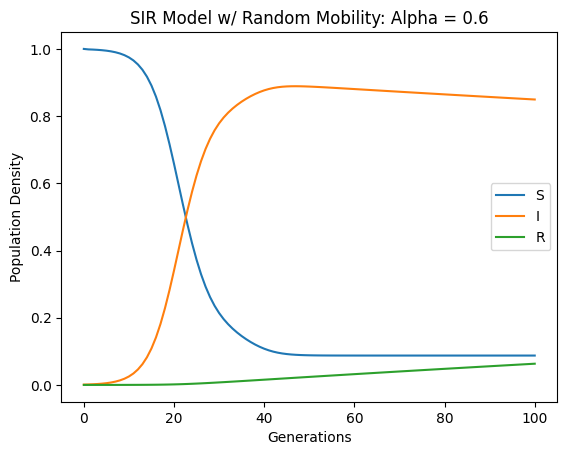

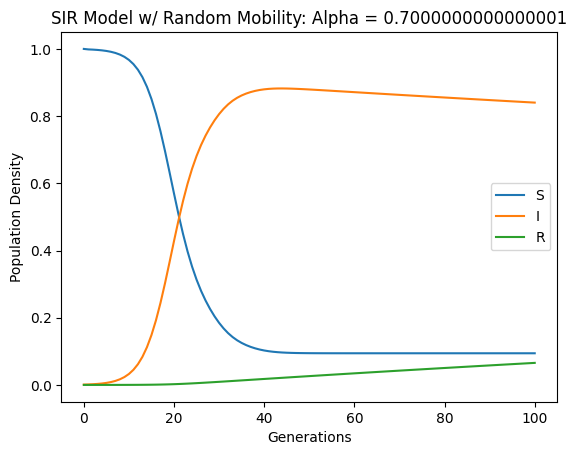

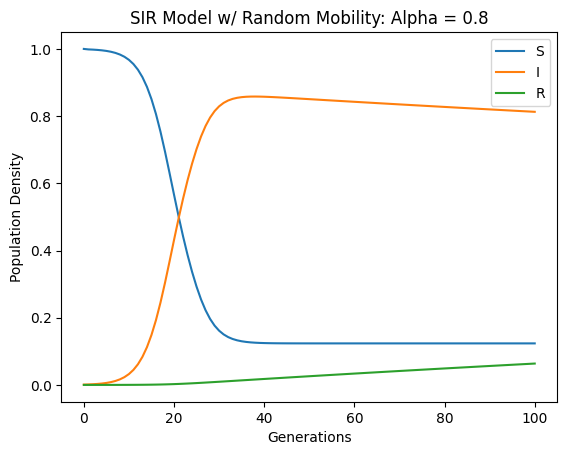

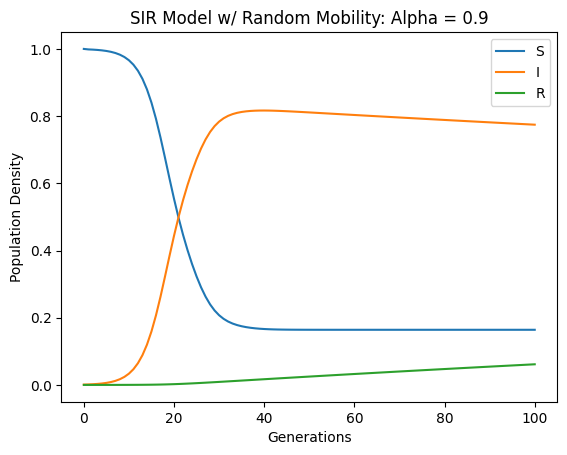

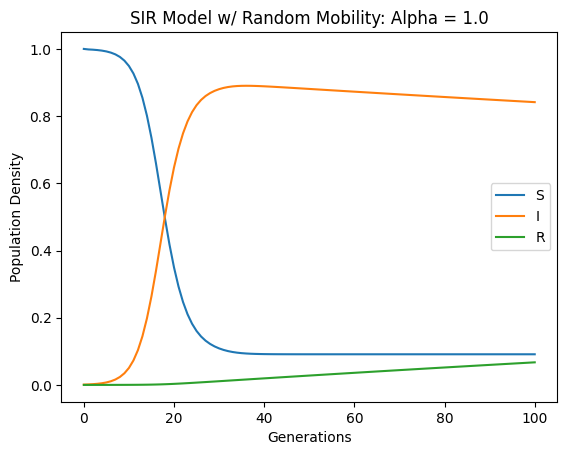

In [103]:
beta = 0.3 # rate of infection *CHANGE LATER MAYBE*
mu = 0.1 # rate of recovery *CHANGE LATER MAYBE*
N = 1000 
n_locations=10
days = 100
alphas = np.arange(0.1,1.1,0.1)
trials=10

type = "Random"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with High Mobility and Dynamic Alpha

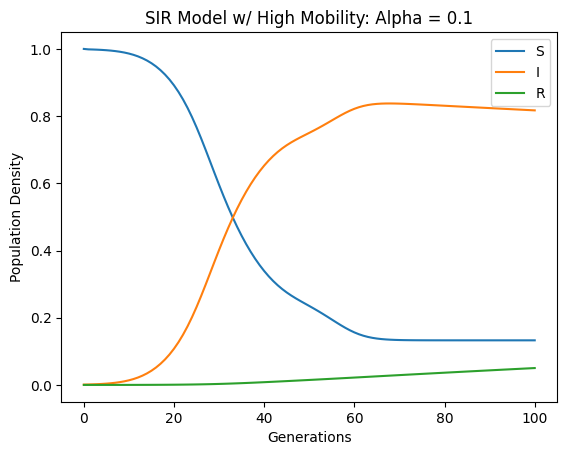

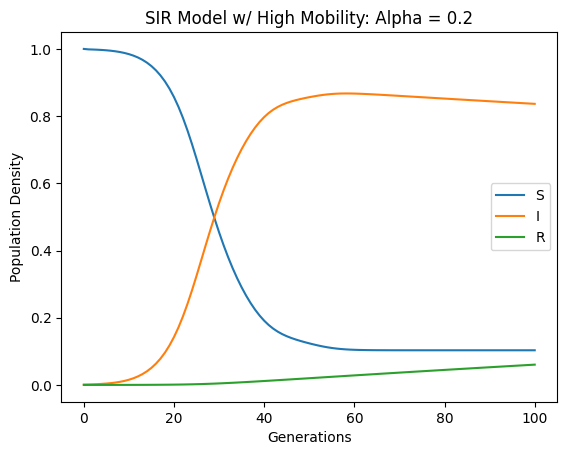

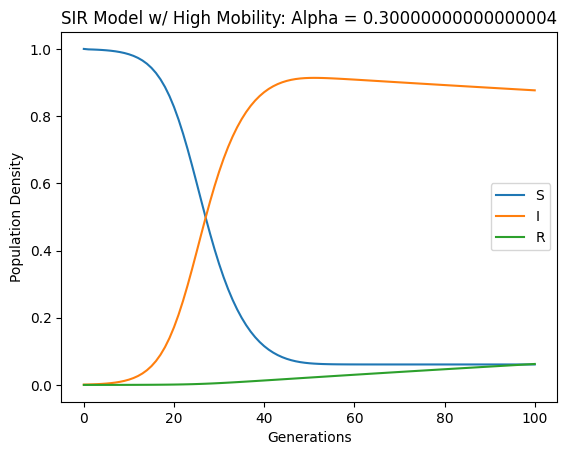

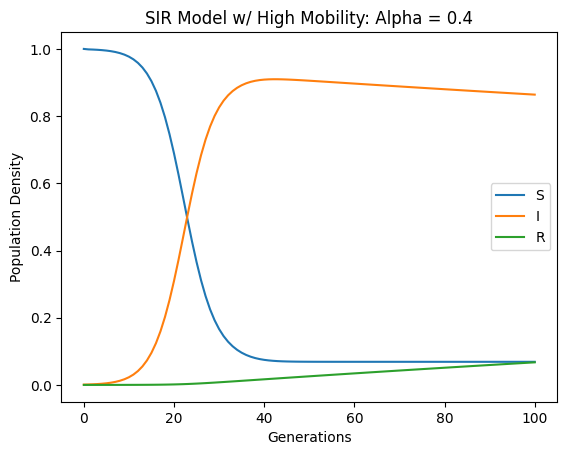

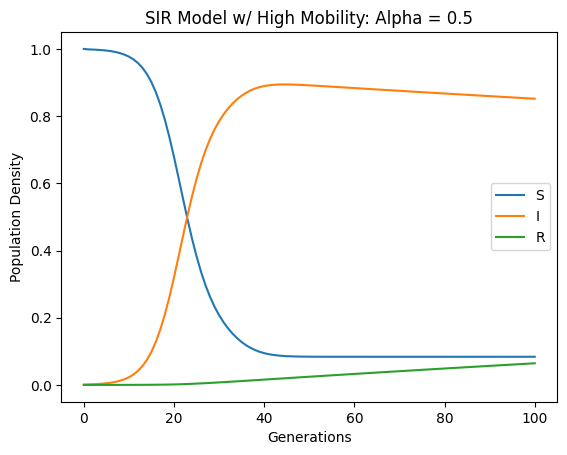

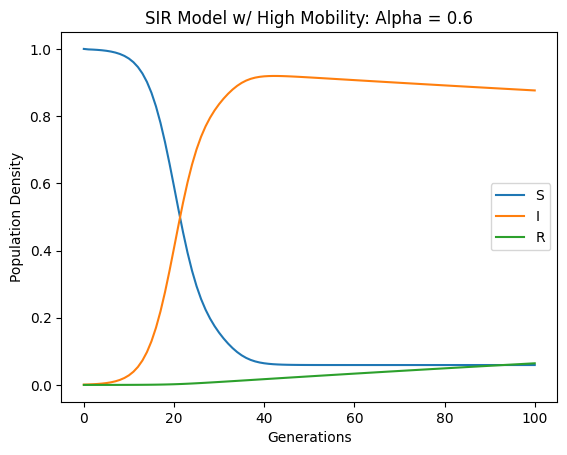

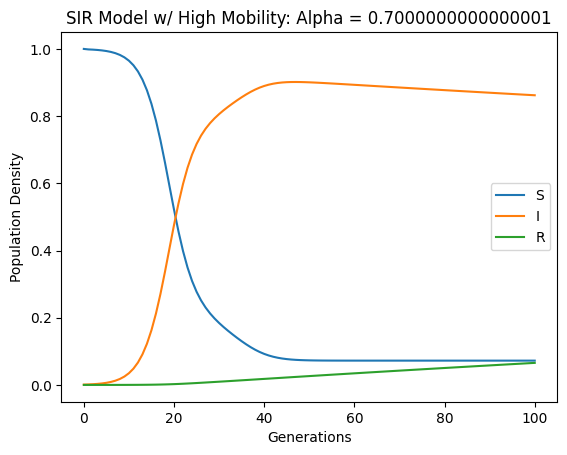

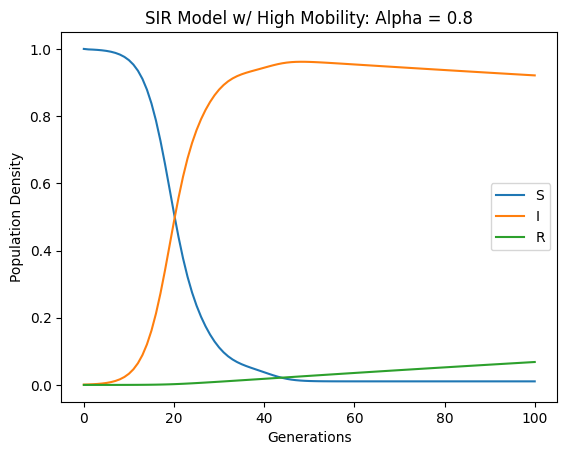

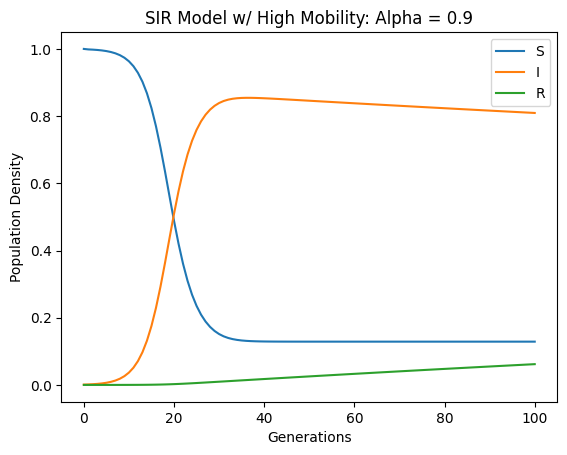

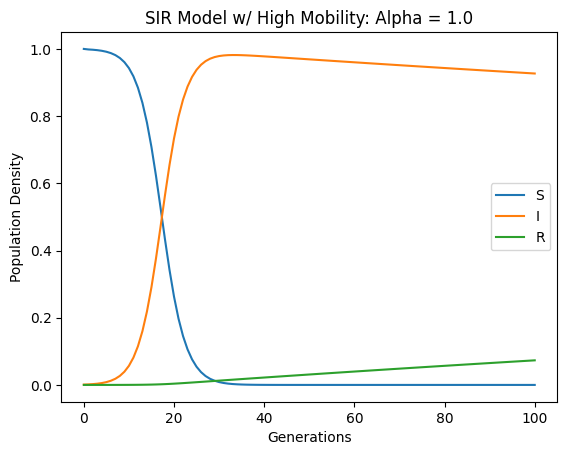

In [104]:
type = "High"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)


### SIR Model with Low Mobility and Dynamic Alpha

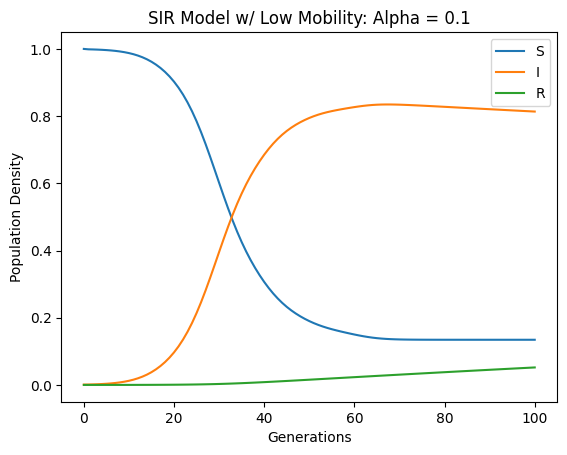

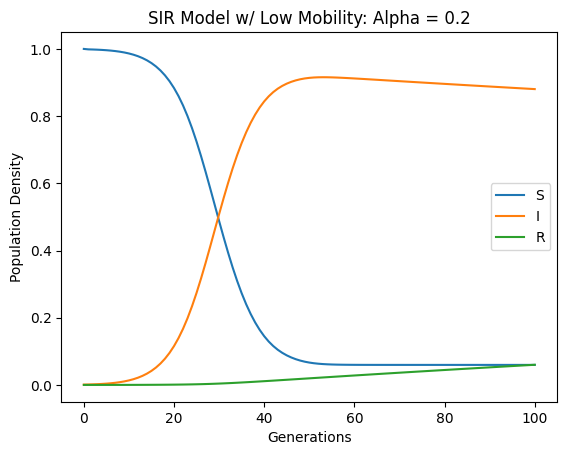

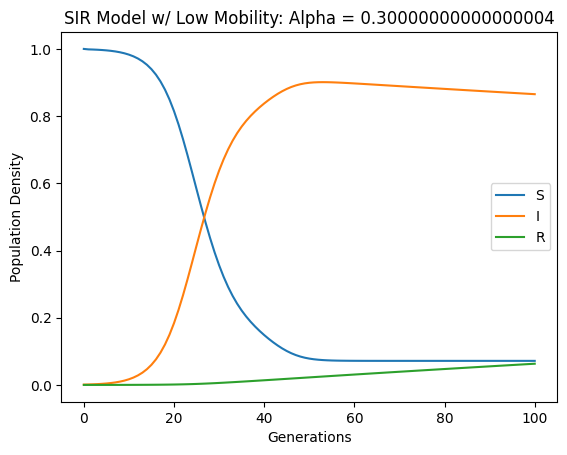

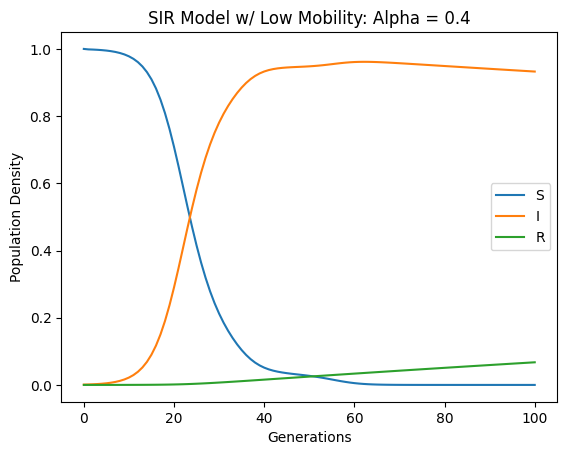

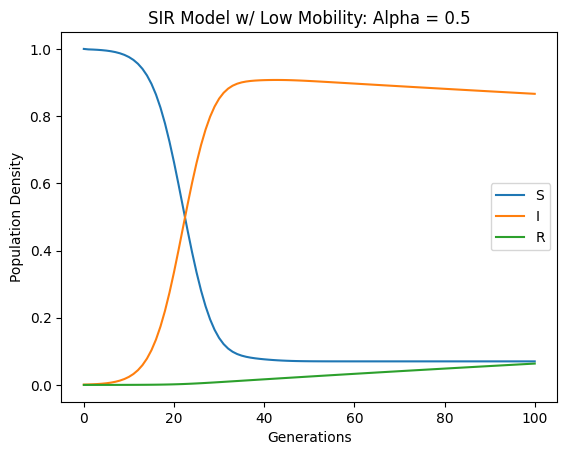

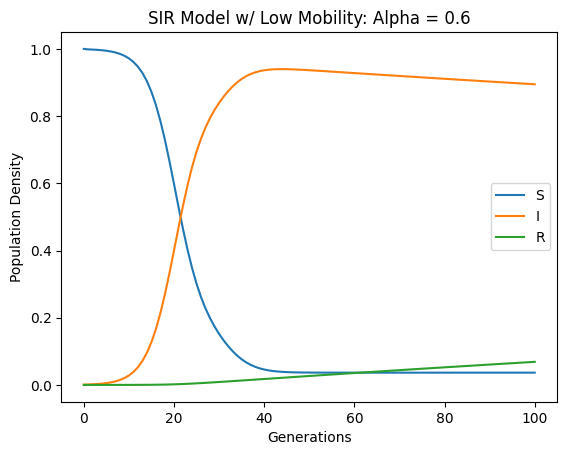

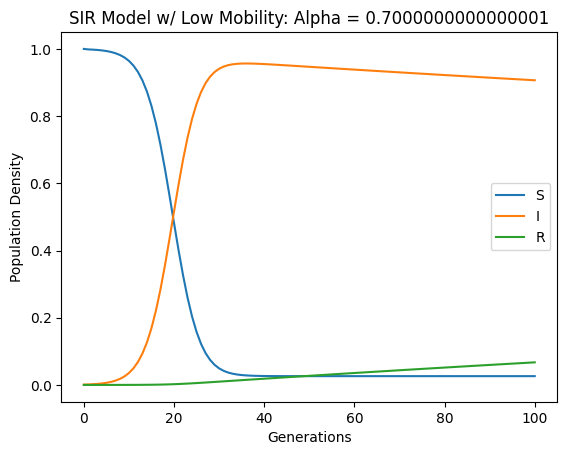

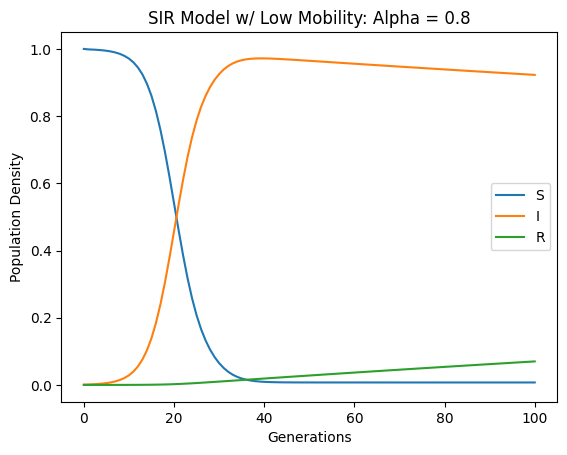

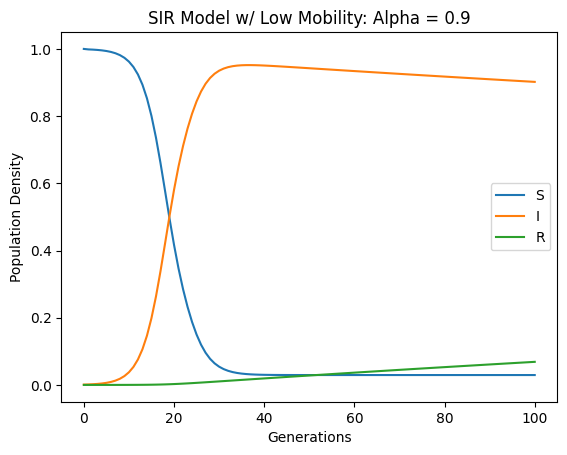

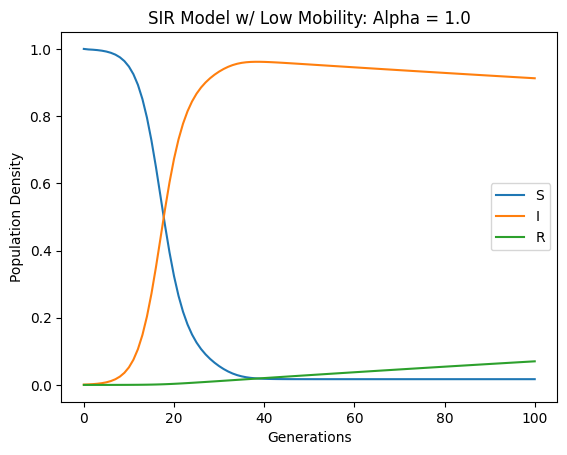

In [105]:
type = "Low"
threshold = 0.1
dynamic_alpha_results = dynamic_alpha(type, threshold, beta, mu, N, n_locations, days, alphas, trials)
translation = {0:"S", 1:"I", 2:"R"}
sir_plotting(dynamic_alpha_results.items(), type)